In [163]:
import pandas as pd
import numpy as np

In [164]:
file_path = "Analysis of States.xlsx"


In [165]:
# List of sheet names in the order specified
sheet_names = [
    "OUTPUT",
    "CENSUS_MHI_STATE",
    "CENSUS_POPULATION_STATE",
    "KEYS"
]

# Load the sheets into a dictionary of DataFrames
dfs_dict = pd.read_excel(file_path, sheet_name=sheet_names)

# Access individual DataFrames by sheet name
df_output = dfs_dict["OUTPUT"]
df_census_mhi_state = dfs_dict["CENSUS_MHI_STATE"]
df_census_population_state = dfs_dict["CENSUS_POPULATION_STATE"]
df_keys = dfs_dict["KEYS"]


In [166]:
df_redfin_median_sale_price = pd.read_excel(file_path, sheet_name="REDFIN_MEDIAN_SALE_PRICE",index_col=0, header=[1])

In [167]:
# Convert the index of the report to tuple. The levels are determined by the
# leading spaces. Every 4 spaces indicate an increase in index level
def convert_to_tuple(input_str):
    stripped_input = input_str.lstrip()
    rank =  int((len(input_str) - len(stripped_input)) / 4)
    output = [np.nan] * (rank + 1)
    output[-1] =  stripped_input
    return tuple(output)


In [168]:
def cleanup_report_dataframe(df):
    df = df.copy()
    df_index = pd.DataFrame(
        df['Label (Grouping)'].map(convert_to_tuple).tolist()
    ).ffill()
    df_index.set_index(df_index.columns.tolist(), inplace=True)
    df.index = df_index.index
    df.drop(["Label (Grouping)"], axis=1, inplace=True)
    df.columns = pd.MultiIndex.from_tuples(
        [tuple(col.split("!!")) for col in df.columns]
    )
    df.replace(r"[^\d\.]+", "", regex=True, inplace=True)
    df.replace(r"", np.nan, inplace=True)
    df = df.astype(np.float64)
    return df

In [169]:
df_census_mhi_state = cleanup_report_dataframe(df_census_mhi_state)
df_census_population_state = cleanup_report_dataframe(df_census_population_state)

C:\Users\mfahmy\AppData\Local\Temp\ipykernel_18612\133412981.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r"", np.nan, inplace=True)
C:\Users\mfahmy\AppData\Local\Temp\ipykernel_18612\133412981.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r"", np.nan, inplace=True)


In [170]:
df_redfin_median_sale_price = df_redfin_median_sale_price\
                            .replace(r"[$]", "", regex=True)\
                            .replace(r"K", "000", regex=True)\
                            .astype(np.float64)

## Helper Functions

In [172]:
def rank_to_str(rank):
    if rank % 100 // 10 == 1:
        return str(rank) + "th"
    elif rank % 10 == 1:
        return str(rank) + "st"
    elif rank % 10 == 2:
        return str(rank) + "nd"
    elif rank % 10 == 3:
        return str(rank) + "rd"
    else:
        return str(rank) + "th"
    

## Global Variables

In [174]:
population_blurb = "{state} is {rank_str} in the nation in population among states, DC, and Puerto Rico."
median_household_income_blurb = "{state} is {rank_str} in the nation in median household income among states, DC, and Puerto Rico."
median_sale_price_blurb = "{state} has the {rank_str} highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from {query_date}."
house_affordability_ratio_blurb = "{state} has the {rank_str} lowest house affordability ratio in the nation among states, DC, and Puerto Rico, according to Redfin data {query_date}." 

In [175]:
query_date = "February 2025"

## Create Ouptut Dataframe

In [177]:
df_lookup = df_keys.query("region_type == 'state'")[["key_row", "zillow_region_name", "alternative_name"]]

In [178]:
df_output = df_lookup.set_index('zillow_region_name').copy()

## Creating Output Dataframe Columns

### census_population

In [181]:
census_population = df_census_population_state\
    .loc[('SEX AND AGE', "Total population", np.nan), (slice(None), "Estimate")].transpose().astype(int)


C:\Users\mfahmy\AppData\Local\Temp\ipykernel_18612\3533247243.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  census_population = df_census_population_state\


In [182]:
census_population.index = [x for x, _ in census_population.index]

In [183]:
df_output['census_population'] = census_population

### population_rank

In [185]:
df_output['population_rank'] = df_output['census_population'].rank(ascending=False).astype(int).apply(rank_to_str)

### population_blurb

In [187]:
df_output["population_blurb"] = df_output.apply(lambda x: population_blurb.format(state=x['alternative_name'], rank_str=x['population_rank']), axis=1)

### median_household_income

In [189]:
df_median_household = df_census_mhi_state\
    .loc[('HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER', "Households", np.nan), (slice(None), "Median income (dollars)", "Estimate")].transpose().astype(int)


C:\Users\mfahmy\AppData\Local\Temp\ipykernel_18612\2909233529.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_median_household = df_census_mhi_state\


In [190]:
df_median_household.index = [x for x, _, _ in df_median_household.index]

In [191]:
df_output['median_household_income'] = df_median_household

### median_household_income_rank

In [193]:
df_output['median_household_income_rank'] = df_output['median_household_income'].rank(ascending=False).astype(int).apply(rank_to_str)

### median_household_income_blurb

In [195]:
df_output["median_household_income_blurb"] = df_output.apply(lambda x: median_household_income_blurb.format(state=x['alternative_name'], rank_str=x['median_household_income_rank']), axis=1)

In [196]:
# Replace the word 1st
first_idx = df_output.query("median_household_income_rank == '1st'").index
df_output.loc[first_idx, 'median_household_income_blurb'] = df_output.loc[first_idx, 'median_household_income_blurb']\
    .replace("1st", "the highest", regex=True)

### median_sale_price

In [198]:
df_output['median_sale_price'] = df_redfin_median_sale_price[pd.to_datetime(query_date)].astype(int)

In [199]:
# Setting some values manually
df_output.loc[["District of Columbia", "Puerto Rico"], "median_sale_price"] = [565000, 138000]

### median_sale_price_rank

In [201]:
df_output['median_sale_price_rank'] = df_output['median_sale_price'].rank(ascending=False).astype(int).apply(rank_to_str)

### median_sale_price_blurb

In [203]:
df_output["median_sale_price_blurb"] = df_output.apply(lambda x: median_sale_price_blurb.format(state=x['alternative_name'], rank_str=x['median_sale_price_rank'], query_date=query_date), axis=1)

In [204]:
# Replace the word 1st
first_idx = df_output.query("median_sale_price_rank == '1st'").index
df_output.loc[first_idx, 'median_sale_price_blurb'] = df_output.loc[first_idx, 'median_sale_price_blurb']\
    .replace("1st", "single", regex=True)

### house_affordability_ratio

In [206]:
df_output['house_affordability_ratio'] = (df_output['median_sale_price'] / df_output['median_household_income'])

### house_affordability_ratio_rank

In [208]:
df_output['house_affordability_ratio_rank'] = df_output['house_affordability_ratio'].rank().astype(int).apply(rank_to_str)

### house_affordability_ratio_blurb

In [210]:
df_output["house_affordability_ratio_blurb"] = df_output.apply(lambda x: house_affordability_ratio_blurb.format(state=x['alternative_name'], rank_str=x['house_affordability_ratio_rank'], query_date=query_date), axis=1)

In [211]:
# Replace the word 1st
first_idx = df_output.query("house_affordability_ratio_rank == '1st'").index
df_output.loc[first_idx, 'house_affordability_ratio_blurb'] = df_output.loc[first_idx, 'house_affordability_ratio_blurb']\
    .replace("1st", "single", regex=True)

# Cleanup

In [214]:
df_output = df_output.set_index('key_row').drop('alternative_name', axis=1)
df_output['house_affordability_ratio'] = df_output['house_affordability_ratio'].round(1)
df_output.to_csv("result.csv")

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
df = df_output

# Clean up data types
df["census_population"] = pd.to_numeric(df["census_population"], errors="coerce")
df["median_household_income"] = pd.to_numeric(df["median_household_income"], errors="coerce")
df["median_sale_price"] = pd.to_numeric(df["median_sale_price"], errors="coerce")
df["house_affordability_ratio"] = pd.to_numeric(df["house_affordability_ratio"], errors="coerce")

# Set consistent theme
sns.set(style="whitegrid")

def bar_chart(data, col, title, xlabel, top=True):
    ordered = data.sort_values(by=col, ascending=not top).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y="key_row", data=ordered, hue="key_row", palette="viridis", dodge=False, legend=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


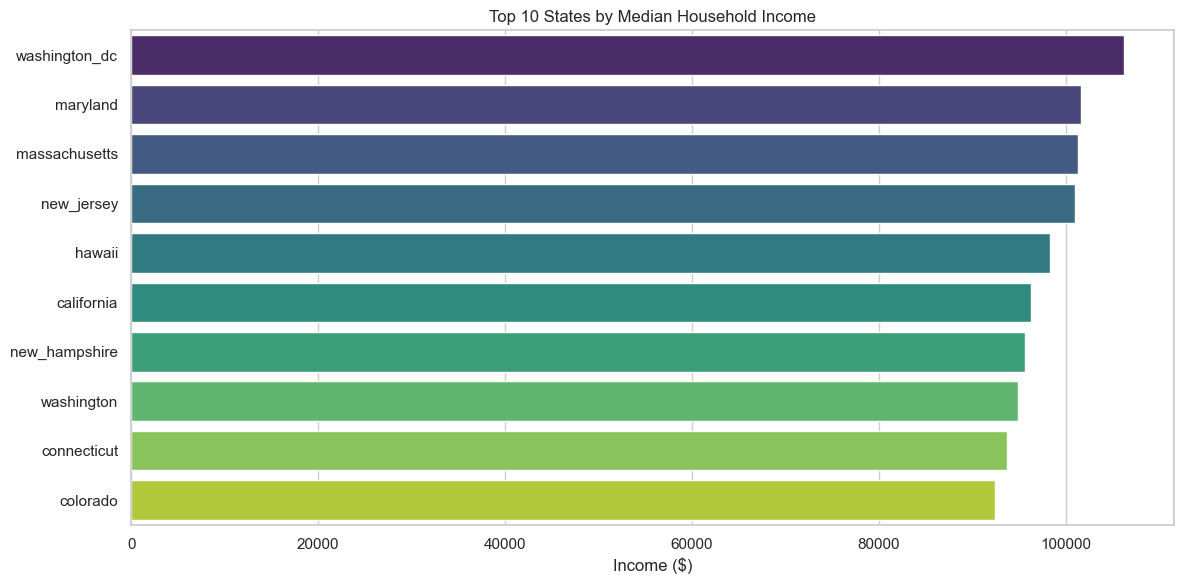

In [216]:
# 1. Top 10 Median Household Income
bar_chart(df, "median_household_income", "Top 10 States by Median Household Income", "Income ($)")

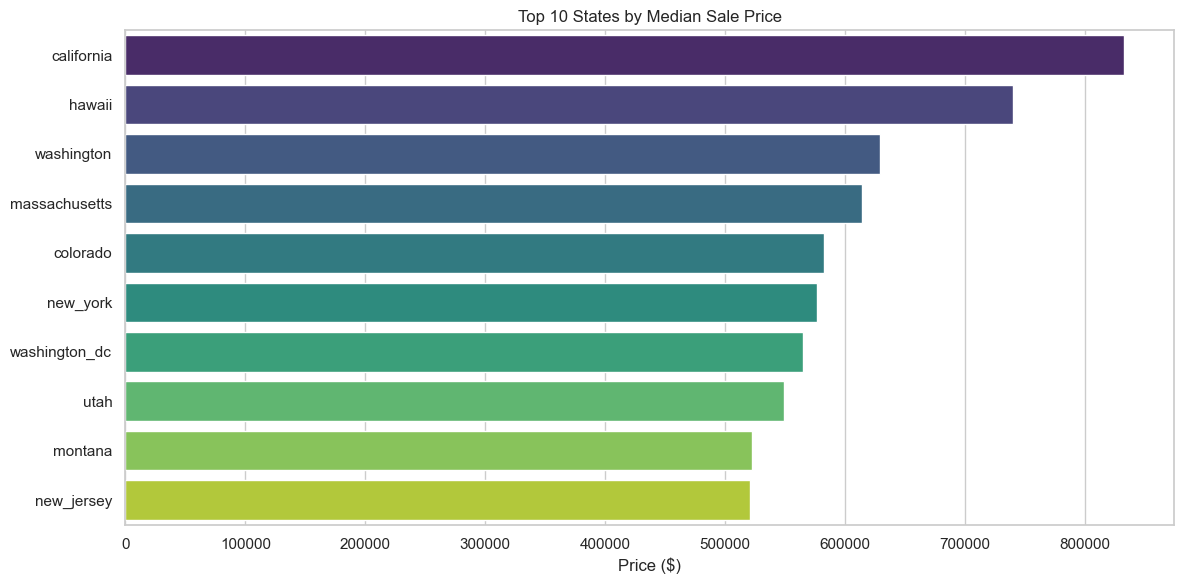

In [217]:
# 2. Top 10 Median Sale Price
bar_chart(df, "median_sale_price", "Top 10 States by Median Sale Price", "Price ($)")

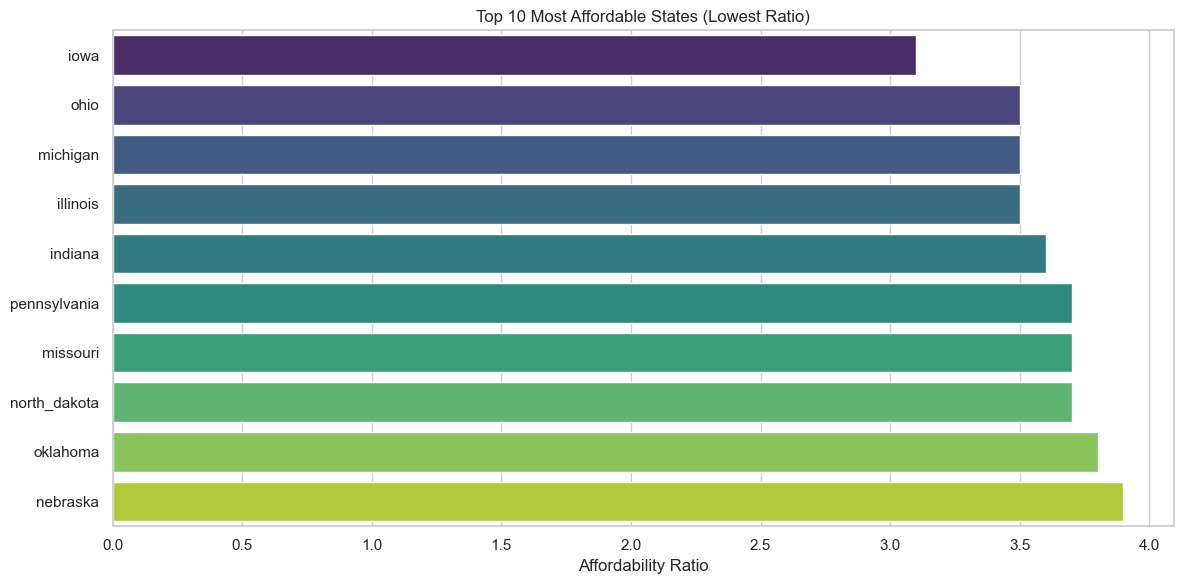

In [218]:
# 3. Bottom 10 House Affordability Ratio (Most Affordable)
bar_chart(df, "house_affordability_ratio", "Top 10 Most Affordable States (Lowest Ratio)", "Affordability Ratio", top=False)

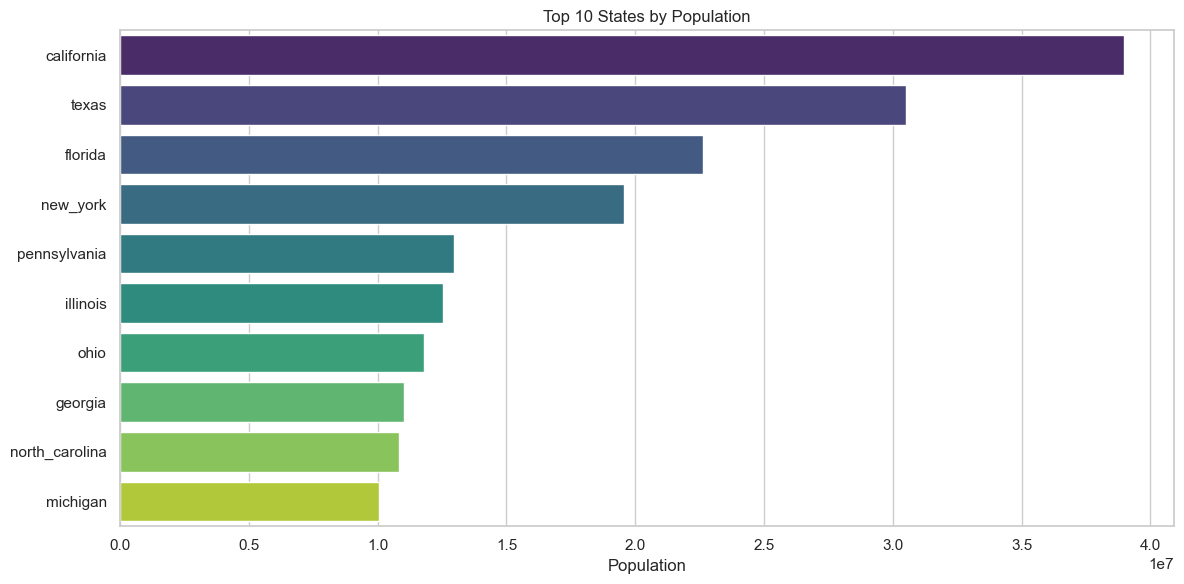

In [219]:
# 4. Top 10 Population
bar_chart(df, "census_population", "Top 10 States by Population", "Population")

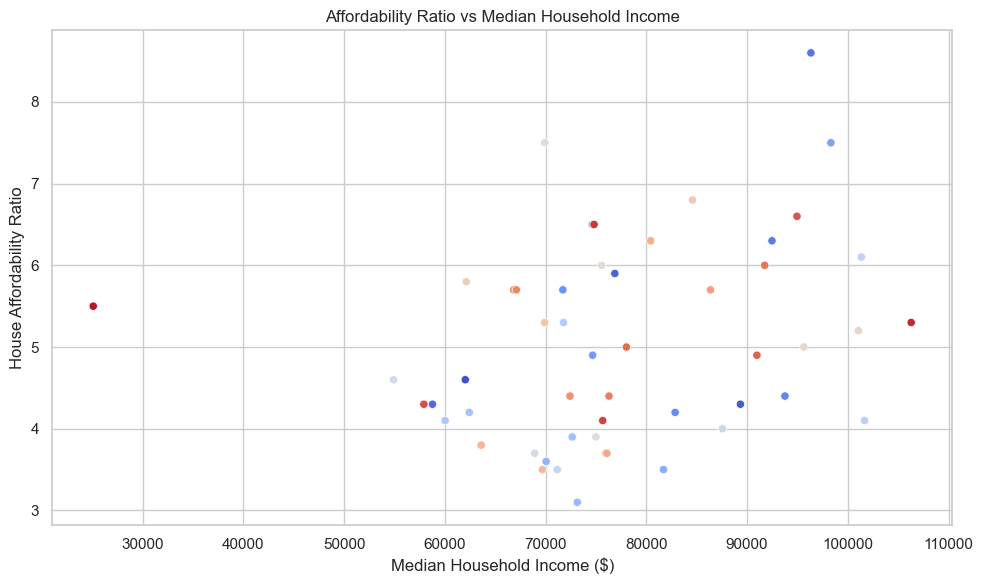

In [220]:
# 5. Scatter Plot - Affordability vs Income
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="median_household_income", y="house_affordability_ratio", hue="key_row", palette="coolwarm", legend=False)
plt.title("Affordability Ratio vs Median Household Income")
plt.xlabel("Median Household Income ($)")
plt.ylabel("House Affordability Ratio")
plt.tight_layout()
plt.show()

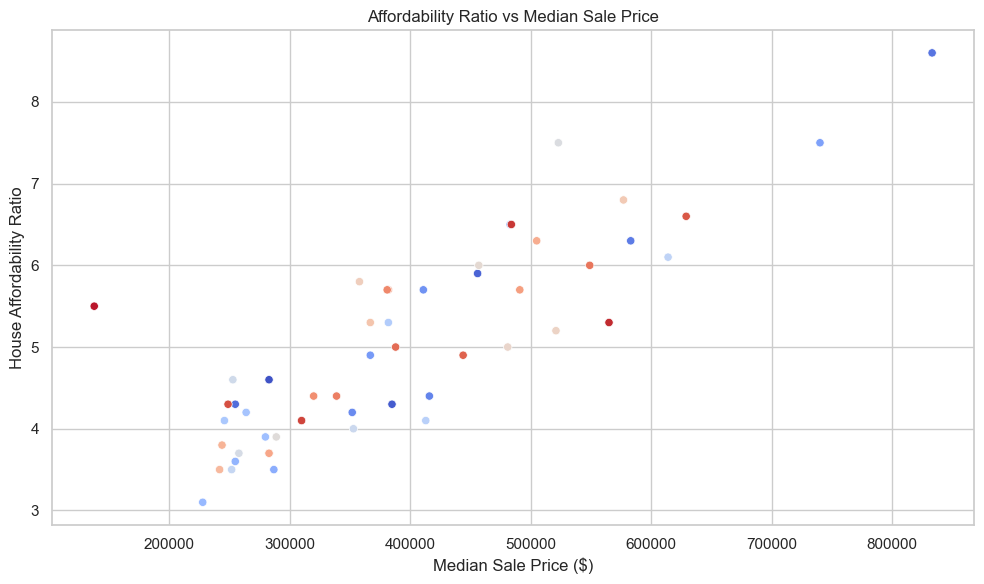

In [221]:
# 6. Scatter Plot - Affordability vs Sale Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="median_sale_price", y="house_affordability_ratio", hue="key_row", palette="coolwarm", legend=False)
plt.title("Affordability Ratio vs Median Sale Price")
plt.xlabel("Median Sale Price ($)")
plt.ylabel("House Affordability Ratio")
plt.tight_layout()
plt.show()